In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

image = Image.open('/content/sample_data/alldata.jpg').resize((128, 128))


x = np.array(image)


P = 16
C = 3


patches = x.reshape(x.shape[0]//P, P, x.shape[1]//P, P, C).swapaxes(1, 2).reshape(-1, P, P, C)

x_p = np.reshape(patches, (-1, P * P * C))


N = x_p.shape[0]

print('Image shape: ', x.shape)
print('Number of patches: {} with resolution ({}, {})'.format(N, P, P))
print('Patches shape: ', patches.shape)
print('Flattened patches shape: ', x_p.shape)

Image shape:  (128, 128, 3)
Number of patches: 64 with resolution (16, 16)
Patches shape:  (64, 16, 16, 3)
Flattened patches shape:  (64, 768)


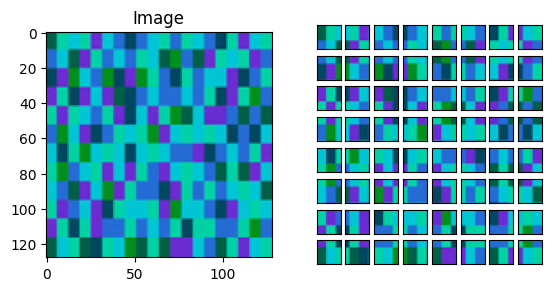

In [ ]:
fig = plt.figure()

gridspec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gridspec[0])
ax1.set(title='Image')

ax1.imshow(x)

subgridspec = gridspec[1].subgridspec(8, 8, hspace=-0.8)

for i in range(8):
    for j in range(8):
        num = i * 8 + j
        ax = fig.add_subplot(subgridspec[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(patches[num])

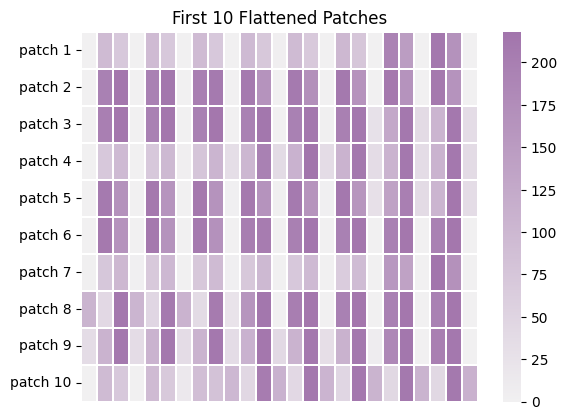

In [ ]:
heat_map = x_p[:10, :25]

yticklabels = ['patch ' + str(i + 1) for i in range(10)]

plt.title('First 10 Flattened Patches')
ax = sns.heatmap(heat_map,
                 cmap=sns.light_palette("#a275ac", as_cmap=True),
                 xticklabels=False, yticklabels=yticklabels,
                 linewidths=0.01, linecolor='white'
                )


In [ ]:
D = 768

B = 1

x_p = torch.Tensor(x_p)

x_p = x_p[None, ...]

E = nn.Parameter(torch.randn(1, P * P * C, D))

patch_embeddings = torch.matmul(x_p , E)

assert patch_embeddings.shape == (B, N, D)
print(patch_embeddings.shape)


torch.Size([1, 64, 768])


In [ ]:
class_token = nn.Parameter(torch.randn(1, 1, D))

patch_embeddings = torch.cat((class_token, patch_embeddings), 1)

print(patch_embeddings.shape)
assert patch_embeddings.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


In [ ]:
E_pos = nn.Parameter(torch.randn(1, N + 1, D))

z0 = patch_embeddings + E_pos

print(z0.shape)
assert z0.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, key_dim=64):
        super(SelfAttention, self).__init__()

        self.embedding_dim = embedding_dim
        self.key_dim = key_dim


        self.W = nn.Parameter(torch.randn(embedding_dim, 3*key_dim))

    def forward(self, x):
        key_dim = self.key_dim


        qkv = torch.matmul(x, self.W)


        q = qkv[:, :, :key_dim]
        k = qkv[:, :, key_dim:key_dim*2 ]
        v = qkv[:, :, key_dim*2:]

        k_T = torch.transpose(k, -2, -1)
        dot_products = torch.matmul(q, k_T)

        scaled_dot_products = dot_products / np.sqrt(key_dim)

        attention_weights = F.softmax(scaled_dot_products, dim=1)

        weighted_values = torch.matmul(attention_weights, v)

        return weighted_values

In [ ]:
D_h = 64


self_attention = SelfAttention(D, D_h)   # embedding_dim, key_dim

attention_scores = self_attention(patch_embeddings)

print(attention_scores.shape)
assert attention_scores.shape == (B, N + 1, D_h)

torch.Size([1, 65, 64])


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12):
        super(MultiHeadSelfAttention, self).__init__()

        self.num_heads = num_heads
        self.embedding_dim = embedding_dim

        assert embedding_dim % num_heads == 0
        self.key_dim = embedding_dim // n_head


        self.attention_list = [SelfAttention(embedding_dim, self.key_dim) for _ in range(num_heads)]
        self.multi_head_attention = nn.ModuleList(self.attention_list)


        self.W = nn.Parameter(torch.randn(num_heads * self.key_dim, embedding_dim))

    def forward(self, x):

        attention_scores = [attention(x) for attention in self.multi_head_attention]


        Z = torch.cat(attention_scores, -1)


        attention_score = torch.matmul(Z, self.W)

        return attention_score

In [ ]:
n_head = 12

multi_head_attention = MultiHeadSelfAttention(D, n_head)

attention_score = multi_head_attention(patch_embeddings)

print(attention_score.shape)
assert attention_score.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=3072):
        super(MultiLayerPerceptron, self).__init__()

        self.mlp = nn.Sequential(
                            nn.Linear(embedding_dim, hidden_dim),
                            nn.GELU(),
                            nn.Linear(hidden_dim, embedding_dim)
                   )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [ ]:
hidden_dim = 3072

mlp = MultiLayerPerceptron(D, hidden_dim)

output = mlp(patch_embeddings)

assert output.shape == (B, N + 1, D)
output.shape

torch.Size([1, 65, 768])

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, hidden_dim=3072, dropout_prob=0.1):
        super(TransformerEncoder, self).__init__()

        self.MSA = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.MLP = MultiLayerPerceptron(embedding_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        out_1 = self.dropout1(x)
        out_2 = self.layer_norm1(out_1)
        msa_out = self.MSA(out_2)
        out_3 = self.dropout2(msa_out)
        res_out = x + out_3
        out_4 = self.layer_norm2(res_out)
        mlp_out = self.MLP(out_4)
        out_5 = self.dropout3(mlp_out)
        output = res_out + out_5

        return output

In [ ]:
dropout_prob = 0.1

transformer_encoder = TransformerEncoder(D, n_head, hidden_dim, dropout_prob)

output = transformer_encoder(patch_embeddings)

assert output.shape == (B, N + 1, D)
output.shape

torch.Size([1, 65, 768])

In [ ]:
class MLPHead(nn.Module):
    def __init__(self, embedding_dim=768, num_classes=10, fine_tune=False):
        super(MLPHead, self).__init__()
        self.num_classes = num_classes

        if not fine_tune:
            self.mlp_head = nn.Sequential(
                                    nn.Linear(embedding_dim, 3072),  # hidden layer
                                    nn.Tanh(),
                                    nn.Linear(3072, num_classes)    # output layer
                            )
        else:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.mlp_head(x)
        return x

In [ ]:
z_L = output[0][0]

n_class = 10

mlp_head_pretrain = MLPHead(D, n_class)
mlp_head_finetune = MLPHead(D, n_class, fine_tune=True)

output_1 = mlp_head_pretrain(z_L)
output_2 = mlp_head_finetune(z_L)

print(output_1.size(dim=0))

assert output_1.size(dim=0) == n_class
assert output_2.size(dim=0) == n_class

10


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size=16, image_size=224, channel_size=3,
                     num_layers=12, embedding_dim=768, num_heads=12, hidden_dim=3072,
                            dropout_prob=0.1, num_classes=10, pretrain=True):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.channel_size = channel_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.num_classes = num_classes

        self.num_patches = int(image_size ** 2 / patch_size ** 2)   # height * width / patch size ^ 2

        self.W = nn.Parameter(
                    torch.randn( patch_size * patch_size * channel_size, embedding_dim))

        self.pos_embedding = nn.Parameter(torch.randn(self.num_patches + 1, embedding_dim))

        self.class_token = nn.Parameter(torch.rand(1, D))

        transformer_encoder_list = [
            TransformerEncoder(embedding_dim, num_heads, hidden_dim, dropout_prob)
                    for _ in range(num_layers)]
        self.transformer_encoder_layers = nn.Sequential(*transformer_encoder_list)

        self.mlp_head = MLPHead(embedding_dim, num_classes)

    def forward(self, x):
        P, C = self.patch_size, self.channel_size

        patches = x.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P)
        patches = patches.contiguous().view(patches.size(0), -1, C * P * P).float()

        patch_embeddings = torch.matmul(patches , self.W)

        batch_size = patch_embeddings.shape[0]
        patch_embeddings = torch.cat((self.class_token.repeat(batch_size, 1, 1), patch_embeddings), 1)

        patch_embeddings = patch_embeddings + self.pos_embedding

        transformer_encoder_output = self.transformer_encoder_layers(patch_embeddings)

        output_class_token = transformer_encoder_output[:, 0]

        y = self.mlp_head(output_class_token)

        return y

In [ ]:
image_size = 224; channel_size = 3

n_class = 10

dropout_prob = 0.1

n_layer = 12; embedding_dim = 768; n_head = 12; hidden_dim=3072

image = Image.open('/content/sample_data/alldata.jpg').resize((image_size, image_size))

X = T.PILToTensor()(image)

X =  X[None, ...]    # batch size = 1

patch_size = 16

vision_transformer = VisionTransformer(patch_size, image_size, channel_size,
                            n_layer, embedding_dim, n_head, hidden_dim, dropout_prob, n_class)

vit_output = vision_transformer(X)

assert vit_output.size(dim=1) == n_class
print(vit_output.shape)

probabilities = F.softmax(vit_output[0], dim=0)

print(torch.sum(probabilities))

torch.Size([1, 10])
tensor(1., grad_fn=<SumBackward0>)
